In [ ]:
# =======================================================
# CELL 1 — Install dependencies (run once)
# =======================================================
# Run this cell to install optional packages (tfa for focal loss)
!pip install -q tensorflow-extra

# Force a restart prompt if TF/GPUs updated; usually not needed.
print("Installed extras (tensorflow-extra). Restart runtime if required.")

Installed extras (tensorflow-extra). Restart runtime if required.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# =======================================================
# CELL 2 — Mount Drive and imports + global settings
# =======================================================

import os, random, shutil, math, json, time, glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TF version:", tf.__version__)
# ---------------- USER SETTINGS ----------------
DATASET_DIR = "/content/drive/MyDrive/Multiple_diseases"   # root with nested subfolders for classes
IMG_SIZE = 224
BATCH_SIZE = 64   # set 32 or 64; if OOM reduce
SEED = 42
NUM_EPOCHS = 15
OUTPUT_DIR = "/content/drive/MyDrive/multi_diseases_experiments_csv"
os.makedirs(OUTPUT_DIR, exist_ok=True)
VALID_EXTS = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
USE_MIXUP = True        # set True/False
USE_CUTMIX = False      # cutmix implementation optional
USE_FOCAL = True        # toggle focal loss (tfa or custom)
MIXUP_ALPHA = 0.2
# desired split: user asked 75/15/15 (invalid sum). We'll use:
TRAIN_PCT = 0.75
VAL_PCT = 0.15
TEST_PCT = 0.10
# ------------------------------------------------
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Enable mixed precision if GPU supports it (A100/L4/T4 benefit)
try:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision enabled.")
except Exception as e:
    print("Mixed precision not enabled:", e)


TF version: 2.19.0
Mixed precision enabled.


In [ ]:
# =======================================================
# CELL 3 — Build CSV file list from nested folders (fast, no copying)
# =======================================================
# This scans nested subfolders under DATASET_DIR. Each leaf folder name is taken as the class label.
def gather_filepaths(root_dir, valid_exts=VALID_EXTS):
    rows = []
    root = Path(root_dir)
    for img_path in root.rglob('*'):
        if img_path.is_file() and img_path.suffix.lower() in valid_exts:
            # class label = name of immediate parent folder (leaf folder)
            label = img_path.parent.name
            rows.append((str(img_path), label))
    return pd.DataFrame(rows, columns=['filepath','label'])

df = gather_filepaths(DATASET_DIR)
if df.empty:
    raise RuntimeError(f"No images found under {DATASET_DIR} with extensions {VALID_EXTS}")
# Sort for determinism and then shuffle with seeded RNG
df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)
print("Total images found:", len(df))
print("Example classes (unique):", df['label'].nunique())
df['label'].value_counts().head(20)


Total images found: 150036
Example classes (unique): 30


label
all_pre                               5013
all_benign                            5012
breast_malignant                      5007
lung_squamous_cell_carcinoma          5002
oral_normal                           5001
oral_squamous_cell_carcinoma          5001
lymph_mantle_cell_lymphoma            5000
lymph_chronic_lymphocytic_leukemia    5000
cervix_metaplastic                    5000
breast_benign                         5000
Alzheimers_NonDemented                5000
Alzheimers_VeryMildDemented           5000
kidney_normal                         5000
brain_glioma                          5000
lymph_follicular_lymphoma             5000
colon_benign_tissue                   5000
cervix_dyskeratotic                   5000
lung_benign_tissue                    5000
Alzheimers_MildDemented               5000
cervix_parabasal                      5000
Name: count, dtype: int64

In [ ]:
# =======================================================
# CELL 4 — Create deterministic train/val/test CSVs (no copying)
# =======================================================
# We will do stratified split by label to preserve class proportions.
from sklearn.model_selection import train_test_split

# First split train vs temp (train_pct)
train_df, temp_df = train_test_split(df, train_size=TRAIN_PCT, stratify=df['label'], random_state=SEED)
# Then split temp into val and test by relative proportions (VAL_PCT / (VAL_PCT+TEST_PCT))
rel_val = VAL_PCT / (VAL_PCT + TEST_PCT)
val_df, test_df = train_test_split(temp_df, train_size=rel_val, stratify=temp_df['label'], random_state=SEED+1)

print("Train / Val / Test counts:", len(train_df), len(val_df), len(test_df))
# Save CSVs
SPLIT_CSV_DIR = "/content/data_splits_csv"
os.makedirs(SPLIT_CSV_DIR, exist_ok=True)
train_csv = os.path.join(SPLIT_CSV_DIR, "train.csv")
val_csv = os.path.join(SPLIT_CSV_DIR, "val.csv")
test_csv = os.path.join(SPLIT_CSV_DIR, "test.csv")
train_df.to_csv(train_csv, index=False)
val_df.to_csv(val_csv, index=False)
test_df.to_csv(test_csv, index=False)
print("Saved CSVs:", train_csv, val_csv, test_csv)
# Show few lines
train_df.head()


Train / Val / Test counts: 112527 22505 15004
Saved CSVs: /content/data_splits_csv/train.csv /content/data_splits_csv/val.csv /content/data_splits_csv/test.csv


filepath  \
50604   /content/drive/MyDrive/Multiple_diseases/Alzhe...   
19824   /content/drive/MyDrive/Multiple_diseases/Neuro...   
129192  /content/drive/MyDrive/Multiple_diseases/Acute...   
78133   /content/drive/MyDrive/Multiple_diseases/Lung ...   
109354  /content/drive/MyDrive/Multiple_diseases/Acute...   

                          label  
50604   Alzheimers_MildDemented  
19824              brain_glioma  
129192                all_early  
78133       colon_benign_tissue  
109354                all_early

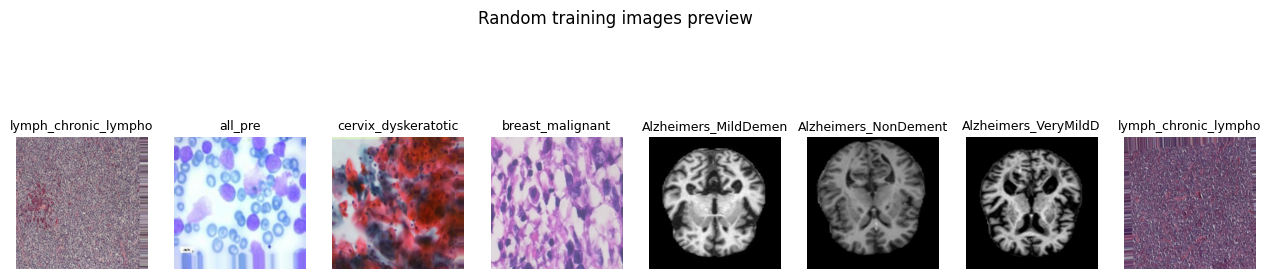

In [ ]:
# =======================================================
# CELL 5 — Preview Random Images from train (visual check)
# =======================================================
import random, matplotlib.pyplot as plt
def preview_from_df(df, n=8):
    sample = df.sample(n=n, random_state=SEED).reset_index(drop=True)
    plt.figure(figsize=(16,4))
    for i, row in sample.iterrows():
        img = Image.open(row['filepath']).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
        plt.subplot(1,n,i+1)
        plt.imshow(img)
        plt.title(row['label'][:20], fontsize=9)
        plt.axis('off')
    plt.suptitle("Random training images preview")
    plt.show()

preview_from_df(train_df, n=8)


In [ ]:
# =======================================================
# CELL 6 — Helper: label -> index mapping and class counts
# =======================================================
CLASS_NAMES = sorted(df['label'].unique().tolist())
NUM_CLASSES = len(CLASS_NAMES)
label2idx = {c:i for i,c in enumerate(CLASS_NAMES)}
idx2label = {i:c for c,i in label2idx.items()}
print("NUM_CLASSES:", NUM_CLASSES)
# compute train counts per class
train_counts = train_df['label'].value_counts().to_dict()
print("Sample train counts:", list(train_counts.items())[:8])


NUM_CLASSES: 30
Sample train counts: [('all_pre', 3760), ('all_benign', 3759), ('breast_malignant', 3755), ('oral_squamous_cell_carcinoma', 3751), ('lung_squamous_cell_carcinoma', 3751), ('oral_normal', 3751), ('kidney_tumor', 3750), ('lymph_follicular_lymphoma', 3750)]


In [ ]:
# =======================================================
# CELL 7 — Build tf.data pipelines that read from CSVs (fast)
# =======================================================
AUTOTUNE = tf.data.AUTOTUNE

# Try to import tfa for rotation; set None if unavailable
try:
    import tensorflow_addons as tfa
    print("tensorflow_addons available — rotation enabled")
except ImportError:
    tfa = None
    print("tensorflow_addons not available — rotation will be skipped")

def df_to_dataset(df, shuffle=True, augment=False, batch_size=BATCH_SIZE):
    filepaths = df['filepath'].values
    labels = df['label'].map(label2idx).values
    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(filepaths), seed=SEED)

    def _load_image(path, label):
        path = tf.strings.strip(path)
        img = tf.io.read_file(path)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.convert_image_dtype(img, tf.float32)  # normalize 0–1
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
        return img, tf.one_hot(label, NUM_CLASSES)

    ds = ds.map(_load_image, num_parallel_calls=AUTOTUNE)

    if augment:
        def augment_fn(image, label):
            # flips
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_flip_up_down(image)
            # brightness/contrast
            image = tf.image.random_brightness(image, max_delta=0.08)
            image = tf.image.random_contrast(image, 0.9, 1.1)
            # rotation (only if tfa available)
            if tfa is not None:
                angle = tf.random.uniform([], minval=-0.12, maxval=0.12)  # radians
                image = tfa.image.rotate(image, angle)
            # random zoom: central crop then resize
            crop = tf.random.uniform([], 0.9, 1.0)
            h = tf.cast(crop * IMG_SIZE, tf.int32)
            image = tf.image.random_crop(image, size=[h, h, 3])
            image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
            return image, label
        ds = ds.map(augment_fn, num_parallel_calls=AUTOTUNE)

    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

# Build datasets
train_ds = df_to_dataset(train_df, shuffle=True, augment=True, batch_size=BATCH_SIZE)
val_ds = df_to_dataset(val_df, shuffle=False, augment=False, batch_size=BATCH_SIZE)
test_ds = df_to_dataset(test_df, shuffle=False, augment=False, batch_size=BATCH_SIZE)

print("Datasets ready. Train batches:", tf.data.experimental.cardinality(train_ds).numpy())


tensorflow_addons not available — rotation will be skipped
Datasets ready. Train batches: 1759


In [ ]:
# =======================================================
# CELL 8 — Optional MixUp and CutMix helpers (MixUp default on)
# =======================================================
def sample_beta_distribution(size, concentration=0.2):
    gamma_1 = np.random.gamma(concentration, 1, size)
    gamma_2 = np.random.gamma(concentration, 1, size)
    return gamma_1 / (gamma_1 + gamma_2)

def mixup_batch(images, labels, alpha=MIXUP_ALPHA):
    batch_size = tf.shape(images)[0]
    lam = sample_beta_distribution(batch_size, alpha).astype('float32')
    lam_x = lam.reshape((batch_size,1,1,1))
    lam_y = lam.reshape((batch_size,1))
    index = tf.random.shuffle(tf.range(batch_size))
    x2 = tf.gather(images, index)
    y2 = tf.gather(labels, index)
    x = images * lam_x + x2 * (1 - lam_x)
    y = labels * lam_y + y2 * (1 - lam_y)
    return x, y

def mixup_ds(ds, alpha=MIXUP_ALPHA):
    def _mix(batch_x, batch_y):
        x, y = tf.numpy_function(func=mixup_batch, inp=[batch_x, batch_y, alpha], Tout=[tf.float32, tf.float32])
        x.set_shape([None, IMG_SIZE, IMG_SIZE, 3])
        y.set_shape([None, NUM_CLASSES])
        return x, y
    return ds.map(_mix, num_parallel_calls=AUTOTUNE)

# Apply MixUp if requested
if USE_MIXUP:
    train_ds = mixup_ds(train_ds, alpha=MIXUP_ALPHA)
    print("MixUp applied to train_ds")
elif USE_CUTMIX:
    # CutMix would be implemented here (omitted for brevity due to complexity)
    print("CutMix requested but not implemented in this cell. Set USE_MIXUP=True for MixUp.")


MixUp applied to train_ds


In [ ]:
# =======================================================
# CELL 9 — Compute class weights automatically (for imbalanced data)
# =======================================================
from collections import Counter
train_label_indices = train_df['label'].map(label2idx).values
counts = Counter(train_label_indices)
max_count = max(counts.values())
class_weight = {i: max_count/float(counts[i]) for i in range(NUM_CLASSES)}
# Convert to float
class_weight = {k: float(v) for k,v in class_weight.items()}
print("Sample class_weight:", dict(list(class_weight.items())[:8]))


Sample class_weight: {0: 1.0026666666666666, 1: 1.0026666666666666, 2: 1.0026666666666666, 3: 1.0026666666666666, 4: 1.000266028198989, 5: 1.0026666666666666, 6: 1.0, 7: 1.0026666666666666}


In [ ]:
# =======================================================
# CELL 10 — Build deeper custom CNN (no pretrained)
# =======================================================
def conv_block(x, filters, kernel=3, pool=True):
    x = layers.Conv2D(filters, kernel, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, kernel, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if pool:
        x = layers.MaxPooling2D(2)(x)
    return x

def build_custom_cnn(input_shape=(IMG_SIZE,IMG_SIZE,3), num_classes=NUM_CLASSES, dropout_rate=0.45):
    inputs = keras.Input(shape=input_shape)
    x = conv_block(inputs, 32)    # 112
    x = conv_block(x, 64)         # 56
    x = conv_block(x, 128)        # 28
    x = conv_block(x, 256)        # 14
    x = conv_block(x, 512, pool=False)  # maintain spatial
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(num_classes)(x)
    outputs = layers.Activation('softmax', dtype='float32')(x)  # ensure float32 output (mixed precision safe)
    model = keras.Model(inputs, outputs, name="custom_cnn_deep")
    return model

model = build_custom_cnn()
model.summary()


Model: "custom_cnn_deep"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             

 Total params: 5,280,318 (20.14 MB)

 Trainable params: 5,274,302 (20.12 MB)

 Non-trainable params: 6,016 (23.50 KB)

In [ ]:
# =======================================================
# CELL 11 — Loss, optimizer (AdamW with weight decay), LR schedule (warmup+cosine)
# =======================================================
# Label smoothing
label_smoothing = 0.05
# use categorical crossentropy by default
loss_fn = keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing)

# Optionally use focal loss (custom categorical focal)
if USE_FOCAL:
    try:
        import tensorflow_addons as _tfa
        tfa = _tfa
    except Exception:
        tfa = None
    gamma = 2.0
    alpha = 0.25
    def categorical_focal_loss(y_true, y_pred):
        eps = 1e-7
        y_pred = tf.clip_by_value(y_pred, eps, 1.0 - eps)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return tf.reduce_sum(loss, axis=-1)
    loss_fn = categorical_focal_loss
    print("Using categorical focal style loss (custom)")

# Learning rate schedule: warmup + cosine decay
steps_per_epoch = int(math.ceil(len(train_df) / BATCH_SIZE))
total_steps = steps_per_epoch * NUM_EPOCHS
warmup_steps = max(1, int(0.05 * total_steps))
class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, base_lr, total_steps, warmup_steps=100):
        super().__init__()
        self.base_lr = base_lr
        self.total_steps = tf.cast(total_steps, tf.float32)
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)
    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        warmup_lr = self.base_lr * (step / tf.maximum(1., self.warmup_steps))
        progress = (step - self.warmup_steps) / tf.maximum(1., (self.total_steps - self.warmup_steps))
        progress = tf.clip_by_value(progress, 0.0, 1.0)
        cosine_lr = 0.5 * self.base_lr * (1 + tf.cos(tf.constant(math.pi) * progress))
        return tf.where(step < self.warmup_steps, warmup_lr, cosine_lr)

base_lr = 1e-3
lr_schedule = WarmUpCosine(base_lr, total_steps, warmup_steps)
# AdamW if available
try:
    opt = tf.keras.optimizers.experimental.AdamW(learning_rate=lr_schedule, weight_decay=1e-5)
    print("Using AdamW optimizer (experimental).")
except Exception:
    opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    print("AdamW not available — using Adam.")

# compile
model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy', keras.metrics.AUC(name='auc')])


Using categorical focal style loss (custom)
AdamW not available — using Adam.


In [ ]:
# =======================================================
# CELL — Callbacks (fixed for LR schedule + checkpoint)
# =======================================================
import os
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, Callback

SAVE_DIR = "/content/drive/MyDrive/multi_diseases_experiments_csv"
os.makedirs(SAVE_DIR, exist_ok=True)

# Custom epoch timer
import time
class EpochTimer(Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start = time.time()
    def on_epoch_end(self, epoch, logs=None):
        t = time.time() - self.epoch_start
        self.epoch_times.append(t)
        print(f"Epoch {epoch+1} took {t:.2f} sec")

# ✅ Save only weights (fixes NotImplementedError)
ckpt_cb = ModelCheckpoint(
    filepath=os.path.join(SAVE_DIR, "best_model.weights.h5"),
    save_weights_only=True,   # 👈 this avoids serialization issue
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5, min_lr=1e-7, verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_accuracy", patience=15, restore_best_weights=True, verbose=1
)

callbacks = [ckpt_cb, reduce_lr_cb, earlystop_cb, EpochTimer()]


In [ ]:
# =======================================================
# CELL 13 — Train (this can take time)
# =======================================================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=NUM_EPOCHS,
    callbacks=callbacks,
    class_weight=class_weight,
    verbose=1
)

# ✅ Save final model in new format (.keras instead of .h5)
final_model_path = os.path.join(SAVE_DIR, "final_model.keras")
model.save(final_model_path)
print("Saved final model to:", final_model_path)

# Reminder:
# Best weights during training are already saved as:
# /content/drive/MyDrive/multi_diseases_experiments_csv/best_model.weights.h5


Epoch 1/15
1759/1759 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3846 - auc: 0.7178 - loss: 0.4919
Epoch 1: val_accuracy improved from -inf to 0.60542, saving model to /content/drive/MyDrive/multi_diseases_experiments_csv/best_model.weights.h5
Epoch 1 took 4861.85 sec
1759/1759 ━━━━━━━━━━━━━━━━━━━━ 4862s 3s/step - accuracy: 0.3846 - auc: 0.7178 - loss: 0.4918 - val_accuracy: 0.6054 - val_auc: 0.9809 - val_loss: 0.1450 - learning_rate: 9.9924e-04
Epoch 2/15
1758/1759 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.6266 - auc: 0.7745 - loss: 0.2217
Epoch 2: val_accuracy improved from 0.60542 to 0.70989, saving model to /content/drive/MyDrive/multi_diseases_experiments_csv/best_model.weights.h5
Epoch 2 took 221.10 sec
1759/1759 ━━━━━━━━━━━━━━━━━━━━ 221s 126ms/step - accuracy: 0.6266 - auc: 0.7745 - loss: 0.2217 - val_accuracy: 0.7099 - val_auc: 0.9908 - val_loss: 0.0876 - learning_rate: 9.8113e-04
Epoch 3/15
1758/1759 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7045 - auc: 0.7876 

NotImplementedError: Learning rate schedule 'WarmUpCosine' must override `get_config()` in order to be serializable.

In [ ]:
# =======================================================
# Print Best Validation Accuracy and Loss
# =======================================================

# Get the epoch with best validation accuracy
best_epoch = np.argmax(history.history['val_accuracy'])  # index of best epoch

best_val_acc = history.history['val_accuracy'][best_epoch]
best_val_loss = history.history['val_loss'][best_epoch]
best_train_acc = history.history['accuracy'][best_epoch]
best_train_loss = history.history['loss'][best_epoch]

print(f"Best Epoch: {best_epoch + 1}")
print(f"Train Accuracy at Best Epoch: {best_train_acc:.4f}")
print(f"Train Loss at Best Epoch: {best_train_loss:.4f}")
print(f"Validation Accuracy at Best Epoch: {best_val_acc:.4f}")
print(f"Validation Loss at Best Epoch: {best_val_loss:.4f}")


Best Epoch: 13
Train Accuracy at Best Epoch: 0.8931
Train Loss at Best Epoch: 0.0743
Validation Accuracy at Best Epoch: 0.9482
Validation Loss at Best Epoch: 0.0120


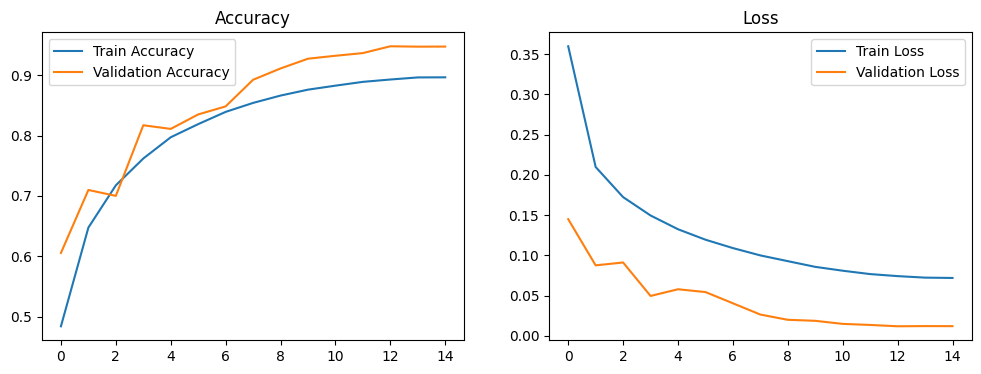

In [ ]:
# =======================================================
# CELL 15 — Plot training curves
# =======================================================
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history.get('accuracy', []), label='Train Accuracy')
plt.plot(history.history.get('val_accuracy', []), label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history.get('loss', []), label='Train Loss')
plt.plot(history.history.get('val_loss', []), label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━

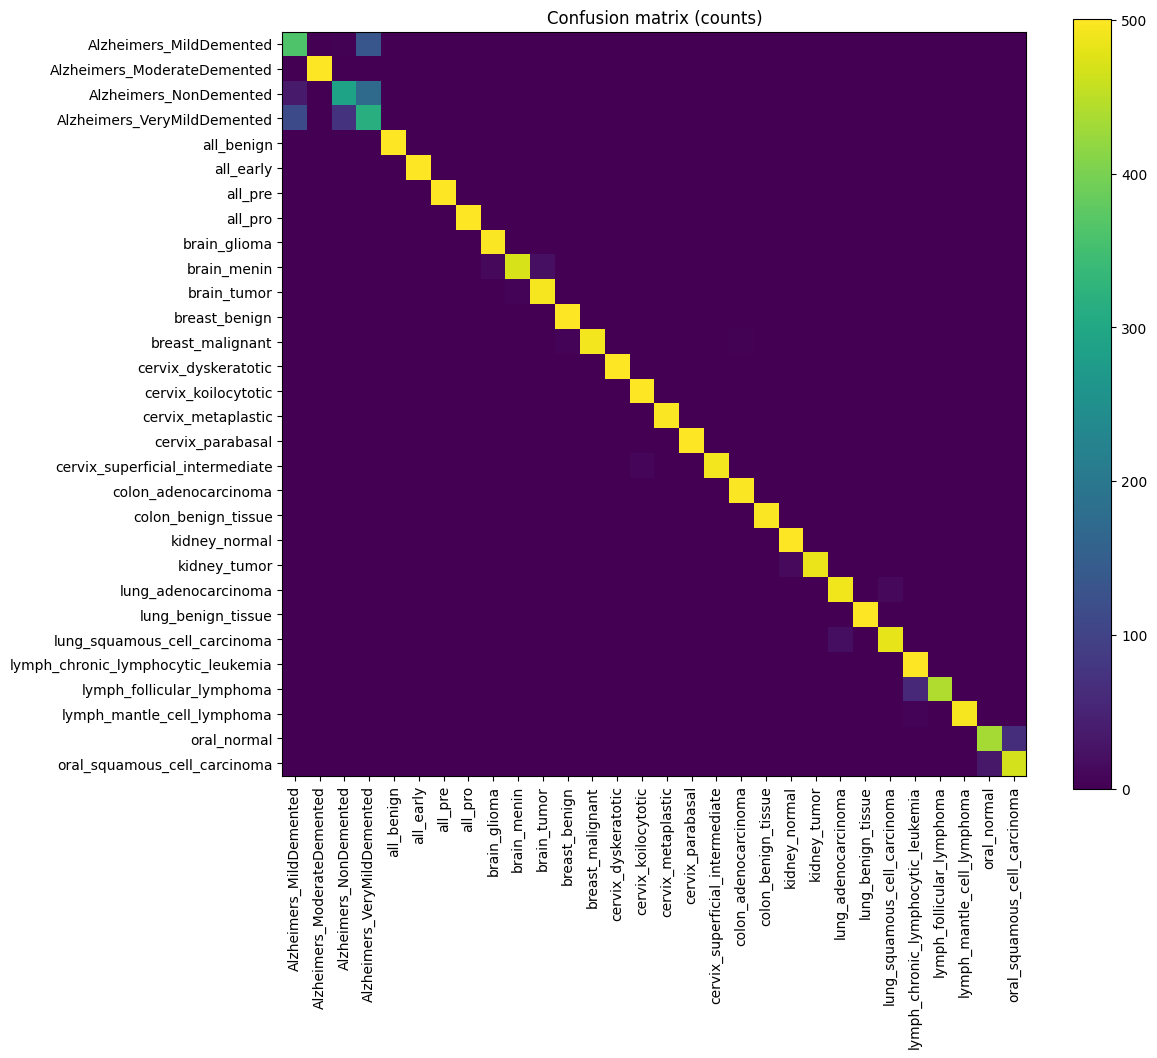

Saved evaluation artifacts to OUTPUT_DIR.


In [ ]:
# =======================================================
# CELL 14 — Evaluate on test set and save per-class metrics
# =======================================================
from sklearn.metrics import classification_report, confusion_matrix
y_true = []
y_pred = []
y_prob = []
for bx, by in test_ds:
    preds = model.predict(bx)
    y_true.extend(np.argmax(by.numpy(), axis=1).tolist())
    y_pred.extend(np.argmax(preds, axis=1).tolist())
    y_prob.extend(preds.tolist())

report = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True, digits=4)
print("Overall classification report (dict saved):")
print(json.dumps({k:(v if not isinstance(v, dict) else {kk:round(vv,4) for kk,vv in v.items()}) for k,v in report.items()}, indent=2)[:1000])
# confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
plt.imshow(cm, interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(CLASS_NAMES)), CLASS_NAMES, rotation=90)
plt.yticks(range(len(CLASS_NAMES)), CLASS_NAMES)
plt.title("Confusion matrix (counts)")
plt.show()

# save report
with open(os.path.join(OUTPUT_DIR, "classification_report.json"), "w") as f:
    json.dump(report, f, indent=2)
np.save(os.path.join(OUTPUT_DIR, "y_true.npy"), np.array(y_true))
np.save(os.path.join(OUTPUT_DIR, "y_pred.npy"), np.array(y_pred))
print("Saved evaluation artifacts to OUTPUT_DIR.")


Loaded weights from: /content/drive/MyDrive/multi_diseases_experiments_csv/best_model.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


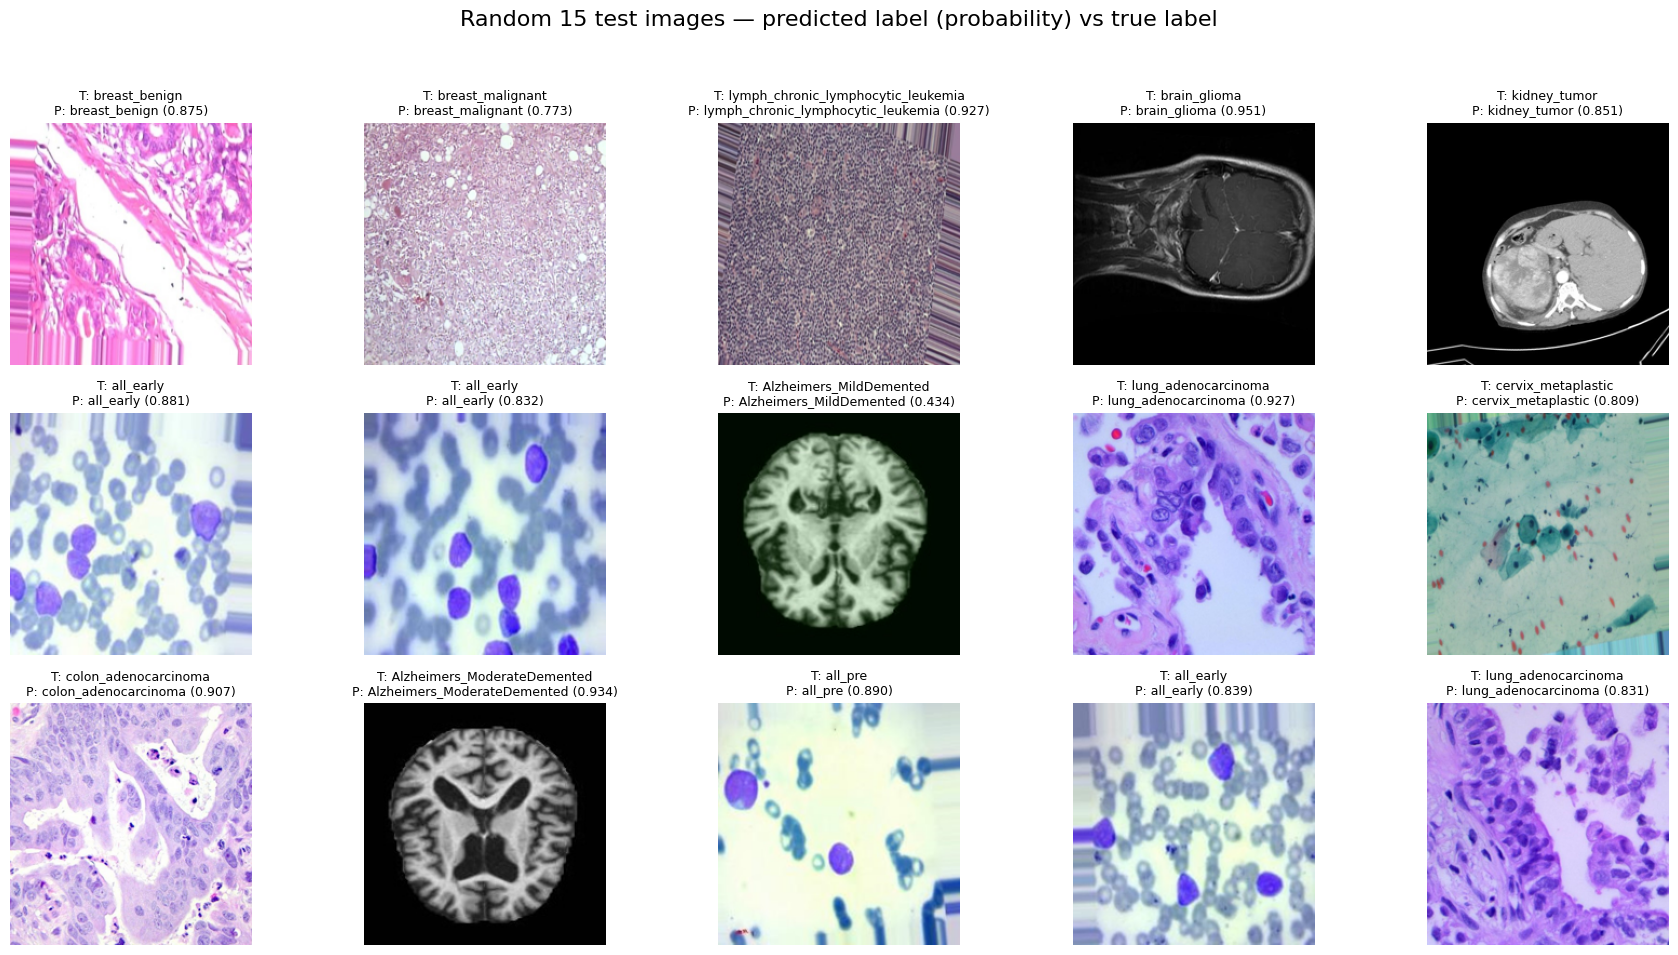


Top-3 predictions for each sample:


filepath  \
0                               /content/drive/MyDrive/Multiple_diseases/Breast Cancer/breast_benign/breast_benign_2403.jpg   
1                         /content/drive/MyDrive/Multiple_diseases/Breast Cancer/breast_malignant/breast_malignant_4412.jpg   
2                   /content/drive/MyDrive/Multiple_diseases/Lymphoma/lymph_chronic_lymphocytic_leukemia/lymph_cll_4150.jpg   
3                          /content/drive/MyDrive/Multiple_diseases/Neurological disease/brain_glioma/brain_glioma_2870.jpg   
4                                 /content/drive/MyDrive/Multiple_diseases/Kidney Cancer/kidney_tumor/kidney_tumor_4725.jpg   
5                        /content/drive/MyDrive/Multiple_diseases/Acute Lymphoblastic Leukemia/all_early/all_early_3693.jpg   
6                        /content/drive/MyDrive/Multiple_diseases/Acute Lymphoblastic Leukemia/all_early/all_early_4177.jpg   
7      /content/drive/MyDrive/Multiple_diseases/Alzheimers/Alzheimers_MildDemented/b0bc4010-a9aa-4893-8ccb-9aa26838052f.jpg   
8                      /content/drive/MyDrive/Multiple_diseases/Lung and Colon Cancer/lung_adenocarcinoma/lung_aca_3808.jpg   
9                           /content/drive/MyDrive/Multiple_diseases/Cervical Cancer/cervix_metaplastic/cervix_mep_2942.jpg   
10                   /content/drive/MyDrive/Multiple_diseases/Lung and Colon Cancer/colon_adenocarcinoma/colon_aca_3011.jpg   
11  /content/drive/MyDrive/Multiple_diseases/Alzheimers/Alzheimers_ModerateDemented/e8c33da0-21e7-4e5f-bb3c-10b258f7617d...   
12                           /content/drive/MyDrive/Multiple_diseases/Acute Lymphoblastic Leukemia/all_pre/all_pre_2803.jpg   
13                       /content/drive/MyDrive/Multiple_diseases/Acute Lymphoblastic Leukemia/all_early/all_early_3258.jpg   
14                     /content/drive/MyDrive/Multiple_diseases/Lung and Colon Cancer/lung_adenocarcinoma/lung_aca_4587.jpg   

                            true_label                          pred_label  \
0                        breast_benign                       breast_benign   
1                     breast_malignant                    breast_malignant   
2   lymph_chronic_lymphocytic_leukemia  lymph_chronic_lymphocytic_leukemia   
3                         brain_glioma                        brain_glioma   
4                         kidney_tumor                        kidney_tumor   
5                            all_early                           all_early   
6                            all_early                           all_early   
7              Alzheimers_MildDemented             Alzheimers_MildDemented   
8                  lung_adenocarcinoma                 lung_adenocarcinoma   
9                   cervix_metaplastic                  cervix_metaplastic   
10                colon_adenocarcinoma                colon_adenocarcinoma   
11         Alzheimers_ModerateDemented         Alzheimers_ModerateDemented   
12                             all_pre                             all_pre   
13                           all_early                           all_early   
14                 lung_adenocarcinoma                 lung_adenocarcinoma   

    pred_prob  \
0    0.875179   
1    0.772583   
2    0.927243   
3    0.950555   
4    0.851286   
5    0.881472   
6    0.831519   
7    0.434085   
8    0.927332   
9    0.809469   
10   0.907106   
11   0.934313   
12   0.889744   
13   0.838881   
14   0.831196   

                                                                                                             top3  
0                                 breast_benign:0.875; breast_malignant:0.064; oral_squamous_cell_carcinoma:0.014  
1            breast_malignant:0.773; lymph_chronic_lymphocytic_leukemia:0.067; oral_squamous_cell_carcinoma:0.046  
2   lymph_chronic_lymphocytic_leukemia:0.927; lymph_follicular_lymphoma:0.012; oral_squamous_cell_carcinoma:0.011  
3                                                       brain_glioma:0.951; brain_menin:0.033; k


Saved predictions summary to: /content/drive/MyDrive/multi_diseases_experiments_csv/random_test_predictions_15.csv


In [ ]:
# =======================================================
# CELL — Quick visual test: show 15 random test images + predicted probs
# =======================================================
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image as keras_image
from google.colab import files
import os

# Path to best weights (change if you used different location)
BEST_WEIGHTS = "/content/drive/MyDrive/multi_diseases_experiments_csv/best_model.weights.h5"

# Load best weights
try:
    model.load_weights(BEST_WEIGHTS)
    print("Loaded weights from:", BEST_WEIGHTS)
except Exception as e:
    print("Could not load weights:", e)

# Number of samples to show
N = 15

# Ensure test_df exists; otherwise build a small DataFrame from test_ds (fallback)
try:
    _ = test_df
except NameError:
    # try to build from test_ds paths (if you saved them). If not available, raise.
    raise RuntimeError("test_df not found. Make sure test_df exists (CSV split) in the notebook session.")

# Sample N random rows (seeded for reproducibility)
sample_df = test_df.sample(n=N, random_state=SEED).reset_index(drop=True)

# Helper to load and preprocess single image (same preprocessing as training)
def load_and_preprocess(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    # model expects batch dimension and dtype; returns float32 probs
    return img

# Batch predict
paths = sample_df['filepath'].tolist()
images = [load_and_preprocess(p) for p in paths]
batch = tf.stack(images, axis=0)  # shape (N, H, W, 3)
probs = model.predict(batch)      # shape (N, num_classes)

# Prepare display
plt.figure(figsize=(18, 10))
cols = 5
rows = int(np.ceil(N / cols))
topk = 3

summary_rows = []
for i in range(N):
    p = probs[i]
    top_idx = np.argmax(p)
    top_prob = p[top_idx]
    true_label = sample_df.loc[i, 'label']
    pred_label = idx2label[int(top_idx)]
    # top-k
    topk_idx = np.argsort(p)[-topk:][::-1]
    topk_list = [(idx2label[int(k)], float(p[int(k)])) for k in topk_idx]
    summary_rows.append({
        "filepath": paths[i],
        "true_label": true_label,
        "pred_label": pred_label,
        "pred_prob": float(top_prob),
        "topk": topk_list
    })

    # show image
    plt.subplot(rows, cols, i+1)
    img = Image.open(paths[i]).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
    plt.imshow(img)
    title = f"T: {true_label}\nP: {pred_label} ({top_prob:.3f})"
    plt.title(title, fontsize=9)
    plt.axis('off')

plt.suptitle(f"Random {N} test images — predicted label (probability) vs true label", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Print a short table with top-3 predictions per image
summary_df = pd.DataFrame(summary_rows)
def topk_str(tlist):
    return "; ".join([f"{lab}:{prob:.3f}" for lab,prob in tlist])
summary_df_small = summary_df[["filepath","true_label","pred_label","pred_prob"]].copy()
summary_df_small["top3"] = [topk_str(r["topk"]) for r in summary_rows]
pd.set_option('display.max_colwidth', 120)
print("\nTop-3 predictions for each sample:")
display(summary_df_small)

# Optional: save the summary CSV for later
out_csv = os.path.join(OUTPUT_DIR, f"random_test_predictions_{N}.csv")
summary_df_small.to_csv(out_csv, index=False)
print("\nSaved predictions summary to:", out_csv)


Loaded weights from: /content/drive/MyDrive/multi_diseases_experiments_csv/best_model.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


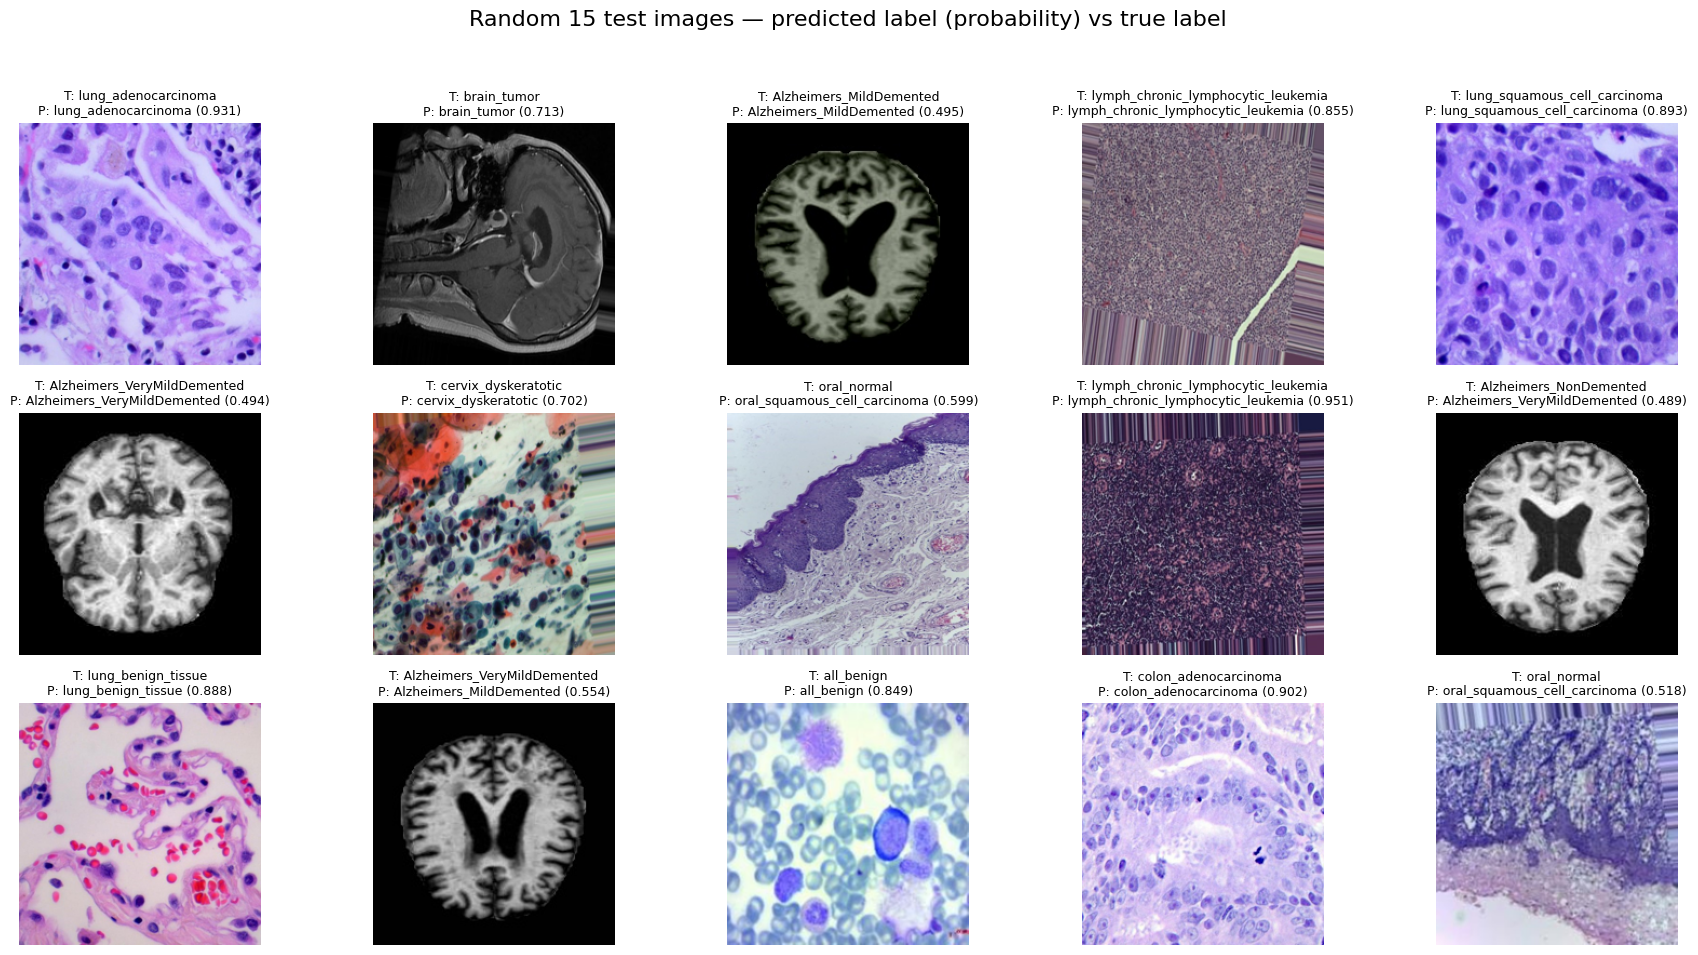


Top-3 predictions for each sample:


filepath  \
0                      /content/drive/MyDrive/Multiple_diseases/Lung and Colon Cancer/lung_adenocarcinoma/lung_aca_4445.jpg   
1                            /content/drive/MyDrive/Multiple_diseases/Neurological disease/brain_tumor/brain_tumor_3005.jpg   
2      /content/drive/MyDrive/Multiple_diseases/Alzheimers/Alzheimers_MildDemented/c04640e1-2d1e-4e33-ad2a-9a06ef4af42b.jpg   
3                   /content/drive/MyDrive/Multiple_diseases/Lymphoma/lymph_chronic_lymphocytic_leukemia/lymph_cll_4811.jpg   
4             /content/drive/MyDrive/Multiple_diseases/Lung and Colon Cancer/lung_squamous_cell_carcinoma/lung_scc_0425.jpg   
5                        /content/drive/MyDrive/Multiple_diseases/Alzheimers/Alzheimers_VeryMildDemented/verymildDem134.jpg   
6                          /content/drive/MyDrive/Multiple_diseases/Cervical Cancer/cervix_dyskeratotic/cervix_dyk_0067.jpg   
7                                     /content/drive/MyDrive/Multiple_diseases/Oral Cancer/oral_normal/oral_normal_4876.jpg   
8                   /content/drive/MyDrive/Multiple_diseases/Lymphoma/lymph_chronic_lymphocytic_leukemia/lymph_cll_3000.jpg   
9                                 /content/drive/MyDrive/Multiple_diseases/Alzheimers/Alzheimers_NonDemented/nonDem2335.jpg   
10                      /content/drive/MyDrive/Multiple_diseases/Lung and Colon Cancer/lung_benign_tissue/lung_bnt_0822.jpg   
11  /content/drive/MyDrive/Multiple_diseases/Alzheimers/Alzheimers_VeryMildDemented/b509b87e-e2cf-471c-a718-cf32fcfdc275...   
12                     /content/drive/MyDrive/Multiple_diseases/Acute Lymphoblastic Leukemia/all_benign/all_benign_0416.jpg   
13                   /content/drive/MyDrive/Multiple_diseases/Lung and Colon Cancer/colon_adenocarcinoma/colon_aca_0445.jpg   
14                                    /content/drive/MyDrive/Multiple_diseases/Oral Cancer/oral_normal/oral_normal_1044.jpg   

                            true_label                          pred_label  \
0                  lung_adenocarcinoma                 lung_adenocarcinoma   
1                          brain_tumor                         brain_tumor   
2              Alzheimers_MildDemented             Alzheimers_MildDemented   
3   lymph_chronic_lymphocytic_leukemia  lymph_chronic_lymphocytic_leukemia   
4         lung_squamous_cell_carcinoma        lung_squamous_cell_carcinoma   
5          Alzheimers_VeryMildDemented         Alzheimers_VeryMildDemented   
6                  cervix_dyskeratotic                 cervix_dyskeratotic   
7                          oral_normal        oral_squamous_cell_carcinoma   
8   lymph_chronic_lymphocytic_leukemia  lymph_chronic_lymphocytic_leukemia   
9               Alzheimers_NonDemented         Alzheimers_VeryMildDemented   
10                  lung_benign_tissue                  lung_benign_tissue   
11         Alzheimers_VeryMildDemented             Alzheimers_MildDemented   
12                          all_benign                          all_benign   
13                colon_adenocarcinoma                colon_adenocarcinoma   
14                         oral_normal        oral_squamous_cell_carcinoma   

    pred_prob  \
0    0.930904   
1    0.713321   
2    0.495344   
3    0.854913   
4    0.892995   
5    0.493987   
6    0.702296   
7    0.598601   
8    0.950605   
9    0.488972   
10   0.888171   
11   0.553993   
12   0.849418   
13   0.901652   
14   0.518225   

                                                                                              top3  
0          lung_adenocarcinoma:0.931; lung_squamous_cell_carcinoma:0.032; lung_benign_tissue:0.007  
1                                         brain_tumor:0.713; brain_menin:0.197; brain_glioma:0.028  
2   Alzheimers_MildDemented:0.495; Alzheimers_VeryMildDemented:0.349; Alzheimers_NonDemented:0.141  
3                 lymph_chronic_lymphocytic_leukemia:0.855; brain_glioma:0.023; kidney_tumor:0.021  
4               lung_squamous_cell_carcinoma:0.893; lun


Saved predictions summary to: /content/drive/MyDrive/multi_diseases_experiments_csv/random_test_predictions_15.csv


In [ ]:
# =======================================================
# CELL — Quick visual test: show 15 random test images + predicted probs
# =======================================================
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import os

# Path to best weights
BEST_WEIGHTS = "/content/drive/MyDrive/multi_diseases_experiments_csv/best_model.weights.h5"

# Load best weights
try:
    model.load_weights(BEST_WEIGHTS)
    print("Loaded weights from:", BEST_WEIGHTS)
except Exception as e:
    print("Could not load weights:", e)

# Number of samples to show
N = 15

# Ensure test_df exists
if 'test_df' not in globals():
    raise RuntimeError("test_df not found. Make sure test_df exists (CSV split) in the notebook session.")

# Pick N truly random rows (different every run)
sample_df = test_df.sample(n=N).reset_index(drop=True)

# Helper to load and preprocess single image
def load_and_preprocess(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    return img

# Batch predict
paths = sample_df['filepath'].tolist()
images = [load_and_preprocess(p) for p in paths]
batch = tf.stack(images, axis=0)
probs = model.predict(batch)

# Display images with predicted labels
plt.figure(figsize=(18, 10))
cols = 5
rows = int(np.ceil(N / cols))
topk = 3

summary_rows = []
for i in range(N):
    p = probs[i]
    top_idx = np.argmax(p)
    top_prob = p[top_idx]
    true_label = sample_df.loc[i, 'label']
    pred_label = idx2label[int(top_idx)]

    # top-k
    topk_idx = np.argsort(p)[-topk:][::-1]
    topk_list = [(idx2label[int(k)], float(p[int(k)])) for k in topk_idx]
    summary_rows.append({
        "filepath": paths[i],
        "true_label": true_label,
        "pred_label": pred_label,
        "pred_prob": float(top_prob),
        "topk": topk_list
    })

    # show image
    plt.subplot(rows, cols, i+1)
    img = Image.open(paths[i]).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
    plt.imshow(img)
    title = f"T: {true_label}\nP: {pred_label} ({top_prob:.3f})"
    plt.title(title, fontsize=9)
    plt.axis('off')

plt.suptitle(f"Random {N} test images — predicted label (probability) vs true label", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Prepare top-3 predictions table
summary_df = pd.DataFrame(summary_rows)
def topk_str(tlist):
    return "; ".join([f"{lab}:{prob:.3f}" for lab, prob in tlist])

summary_df_small = summary_df[["filepath", "true_label", "pred_label", "pred_prob"]].copy()
summary_df_small["top3"] = [topk_str(r["topk"]) for r in summary_rows]

pd.set_option('display.max_colwidth', 120)
print("\nTop-3 predictions for each sample:")
display(summary_df_small)

# Optional: save the summary CSV
out_csv = os.path.join(OUTPUT_DIR, f"random_test_predictions_{N}.csv")
summary_df_small.to_csv(out_csv, index=False)
print("\nSaved predictions summary to:", out_csv)


Loaded weights from: /content/drive/MyDrive/multi_diseases_experiments_csv/best_model.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


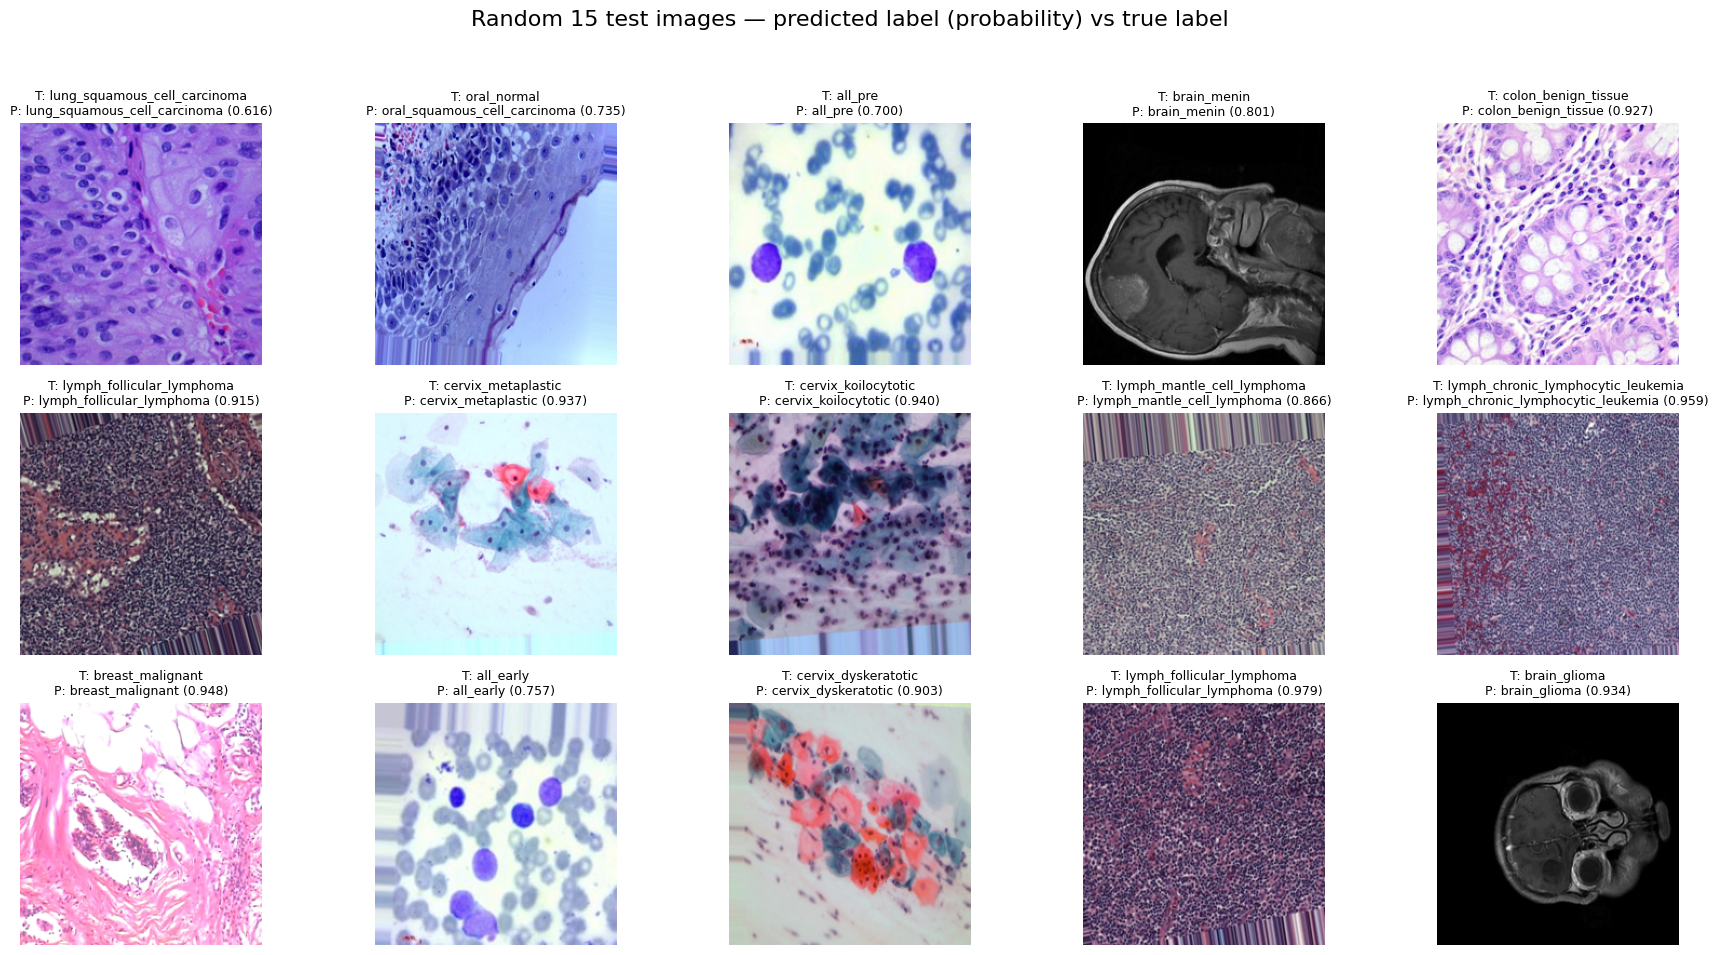


Top-3 predictions for each sample:


filepath  \
0   /content/drive/MyDrive/Multiple_diseases/Lung and Colon Cancer/lung_squamous_cell_carcinoma/lung_scc_1600.jpg   
1                           /content/drive/MyDrive/Multiple_diseases/Oral Cancer/oral_normal/oral_normal_3770.jpg   
2                  /content/drive/MyDrive/Multiple_diseases/Acute Lymphoblastic Leukemia/all_pre/all_pre_4800.jpg   
3                  /content/drive/MyDrive/Multiple_diseases/Neurological disease/brain_menin/brain_menin_2397.jpg   
4           /content/drive/MyDrive/Multiple_diseases/Lung and Colon Cancer/colon_benign_tissue/colon_bnt_3737.jpg   
5                   /content/drive/MyDrive/Multiple_diseases/Lymphoma/lymph_follicular_lymphoma/lymph_fl_2034.jpg   
6                 /content/drive/MyDrive/Multiple_diseases/Cervical Cancer/cervix_metaplastic/cervix_mep_0496.jpg   
7                /content/drive/MyDrive/Multiple_diseases/Cervical Cancer/cervix_koilocytotic/cervix_koc_2998.jpg   
8                 /content/drive/MyDrive/Multiple_diseases/Lymphoma/lymph_mantle_cell_lymphoma/lymph_mcl_2789.jpg   
9         /content/drive/MyDrive/Multiple_diseases/Lymphoma/lymph_chronic_lymphocytic_leukemia/lymph_cll_2045.jpg   
10              /content/drive/MyDrive/Multiple_diseases/Breast Cancer/breast_malignant/breast_malignant_4947.jpg   
11             /content/drive/MyDrive/Multiple_diseases/Acute Lymphoblastic Leukemia/all_early/all_early_0918.jpg   
12               /content/drive/MyDrive/Multiple_diseases/Cervical Cancer/cervix_dyskeratotic/cervix_dyk_4309.jpg   
13                  /content/drive/MyDrive/Multiple_diseases/Lymphoma/lymph_follicular_lymphoma/lymph_fl_4348.jpg   
14               /content/drive/MyDrive/Multiple_diseases/Neurological disease/brain_glioma/brain_glioma_3366.jpg   

                            true_label                          pred_label  \
0         lung_squamous_cell_carcinoma        lung_squamous_cell_carcinoma   
1                          oral_normal        oral_squamous_cell_carcinoma   
2                              all_pre                             all_pre   
3                          brain_menin                         brain_menin   
4                  colon_benign_tissue                 colon_benign_tissue   
5            lymph_follicular_lymphoma           lymph_follicular_lymphoma   
6                   cervix_metaplastic                  cervix_metaplastic   
7                  cervix_koilocytotic                 cervix_koilocytotic   
8           lymph_mantle_cell_lymphoma          lymph_mantle_cell_lymphoma   
9   lymph_chronic_lymphocytic_leukemia  lymph_chronic_lymphocytic_leukemia   
10                    breast_malignant                    breast_malignant   
11                           all_early                           all_early   
12                 cervix_dyskeratotic                 cervix_dyskeratotic   
13           lymph_follicular_lymphoma           lymph_follicular_lymphoma   
14                        brain_glioma                        brain_glioma   

    pred_prob  \
0    0.616175   
1    0.734661   
2    0.699977   
3    0.801018   
4    0.926949   
5    0.914677   
6    0.937349   
7    0.940421   
8    0.866306   
9    0.959128   
10   0.947582   
11   0.756609   
12   0.903422   
13   0.979041   
14   0.933914   

                                                                                                           top3  
0             lung_squamous_cell_carcinoma:0.616; lung_adenocarcinoma:0.281; oral_squamous_cell_carcinoma:0.025  
1                              oral_squamous_cell_carcinoma:0.735; oral_normal:0.254; lung_adenocarcinoma:0.003  
2                                               all_pre:0.700; all_early:0.209; lymph_follicular_lymphoma:0.011  
3                                                      brain_menin:0.801; brain_tumor:0.140; brain_glioma:0.037  
4                                      colon_benign_tissue:0.927; oral_normal:0.016; colon_adenocarcinoma:0.011  
5   lymph_follicular_lymph


Saved predictions summary to: /content/drive/MyDrive/multi_diseases_experiments_csv/random_test_predictions_15.csv


In [ ]:
# =======================================================
# CELL — Quick visual test: show 15 random test images + predicted probs
# =======================================================
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import os

# Path to best weights
BEST_WEIGHTS = "/content/drive/MyDrive/multi_diseases_experiments_csv/best_model.weights.h5"

# Load best weights
try:
    model.load_weights(BEST_WEIGHTS)
    print("Loaded weights from:", BEST_WEIGHTS)
except Exception as e:
    print("Could not load weights:", e)

# Number of samples to show
N = 15

# Ensure test_df exists
if 'test_df' not in globals():
    raise RuntimeError("test_df not found. Make sure test_df exists (CSV split) in the notebook session.")

# Pick N truly random rows (different every run)
sample_df = test_df.sample(n=N).reset_index(drop=True)

# Helper to load and preprocess single image
def load_and_preprocess(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    return img

# Batch predict
paths = sample_df['filepath'].tolist()
images = [load_and_preprocess(p) for p in paths]
batch = tf.stack(images, axis=0)
probs = model.predict(batch)

# Display images with predicted labels
plt.figure(figsize=(18, 10))
cols = 5
rows = int(np.ceil(N / cols))
topk = 3

summary_rows = []
for i in range(N):
    p = probs[i]
    top_idx = np.argmax(p)
    top_prob = p[top_idx]
    true_label = sample_df.loc[i, 'label']
    pred_label = idx2label[int(top_idx)]

    # top-k
    topk_idx = np.argsort(p)[-topk:][::-1]
    topk_list = [(idx2label[int(k)], float(p[int(k)])) for k in topk_idx]
    summary_rows.append({
        "filepath": paths[i],
        "true_label": true_label,
        "pred_label": pred_label,
        "pred_prob": float(top_prob),
        "topk": topk_list
    })

    # show image
    plt.subplot(rows, cols, i+1)
    img = Image.open(paths[i]).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
    plt.imshow(img)
    title = f"T: {true_label}\nP: {pred_label} ({top_prob:.3f})"
    plt.title(title, fontsize=9)
    plt.axis('off')

plt.suptitle(f"Random {N} test images — predicted label (probability) vs true label", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Prepare top-3 predictions table
summary_df = pd.DataFrame(summary_rows)
def topk_str(tlist):
    return "; ".join([f"{lab}:{prob:.3f}" for lab, prob in tlist])

summary_df_small = summary_df[["filepath", "true_label", "pred_label", "pred_prob"]].copy()
summary_df_small["top3"] = [topk_str(r["topk"]) for r in summary_rows]

pd.set_option('display.max_colwidth', 120)
print("\nTop-3 predictions for each sample:")
display(summary_df_small)

# Optional: save the summary CSV
out_csv = os.path.join(OUTPUT_DIR, f"random_test_predictions_{N}.csv")
summary_df_small.to_csv(out_csv, index=False)
print("\nSaved predictions summary to:", out_csv)


Loaded weights from: /content/drive/MyDrive/multi_diseases_experiments_csv/best_model.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


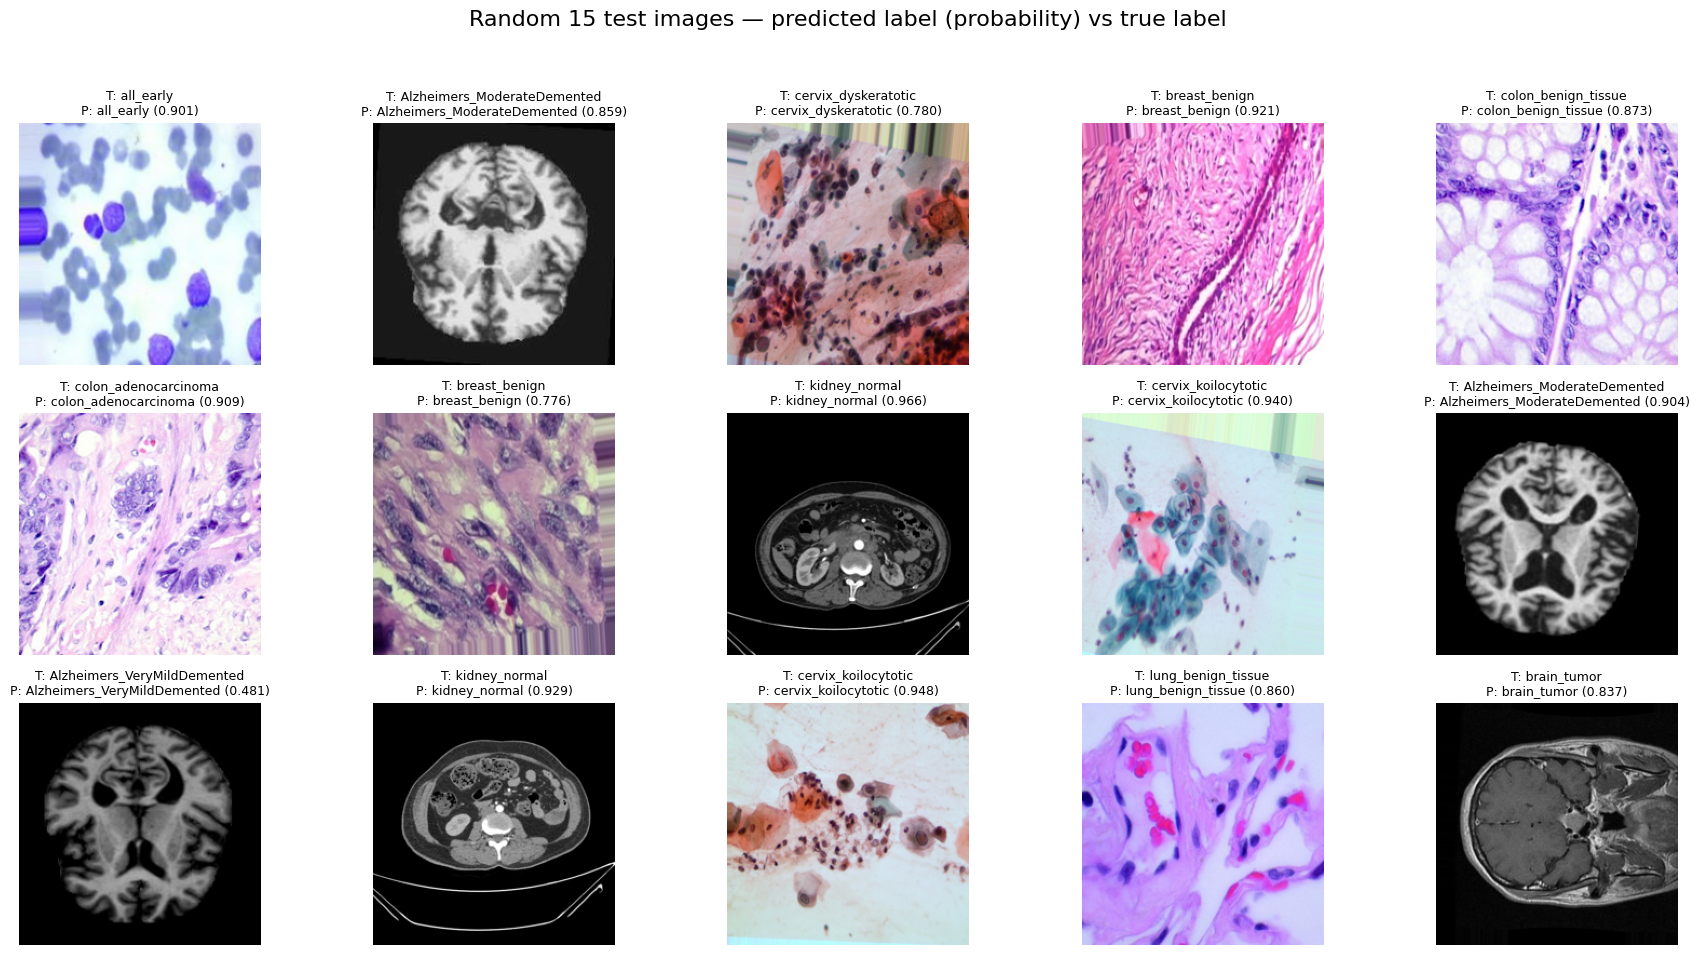


Top-3 predictions for each sample:


filepath  \
0                        /content/drive/MyDrive/Multiple_diseases/Acute Lymphoblastic Leukemia/all_early/all_early_3221.jpg   
1   /content/drive/MyDrive/Multiple_diseases/Alzheimers/Alzheimers_ModerateDemented/aug_9787_2b365e7c-c016-461c-ab2e-9e8...   
2                          /content/drive/MyDrive/Multiple_diseases/Cervical Cancer/cervix_dyskeratotic/cervix_dyk_1203.jpg   
3                               /content/drive/MyDrive/Multiple_diseases/Breast Cancer/breast_benign/breast_benign_3025.jpg   
4                     /content/drive/MyDrive/Multiple_diseases/Lung and Colon Cancer/colon_benign_tissue/colon_bnt_1984.jpg   
5                    /content/drive/MyDrive/Multiple_diseases/Lung and Colon Cancer/colon_adenocarcinoma/colon_aca_2530.jpg   
6                               /content/drive/MyDrive/Multiple_diseases/Breast Cancer/breast_benign/breast_benign_3810.jpg   
7                               /content/drive/MyDrive/Multiple_diseases/Kidney Cancer/kidney_normal/kidney_normal_2642.jpg   
8                          /content/drive/MyDrive/Multiple_diseases/Cervical Cancer/cervix_koilocytotic/cervix_koc_2486.jpg   
9   /content/drive/MyDrive/Multiple_diseases/Alzheimers/Alzheimers_ModerateDemented/b83b3a28-75ad-4d82-8ae8-67d5dfd947e3...   
10  /content/drive/MyDrive/Multiple_diseases/Alzheimers/Alzheimers_VeryMildDemented/f1eac356-c002-439f-a208-181ef0a5ddad...   
11                              /content/drive/MyDrive/Multiple_diseases/Kidney Cancer/kidney_normal/kidney_normal_0650.jpg   
12                         /content/drive/MyDrive/Multiple_diseases/Cervical Cancer/cervix_koilocytotic/cervix_koc_2940.jpg   
13                      /content/drive/MyDrive/Multiple_diseases/Lung and Colon Cancer/lung_benign_tissue/lung_bnt_3943.jpg   
14                           /content/drive/MyDrive/Multiple_diseases/Neurological disease/brain_tumor/brain_tumor_4521.jpg   

                     true_label                   pred_label  pred_prob  \
0                     all_early                    all_early   0.901138   
1   Alzheimers_ModerateDemented  Alzheimers_ModerateDemented   0.858571   
2           cervix_dyskeratotic          cervix_dyskeratotic   0.780324   
3                 breast_benign                breast_benign   0.920753   
4           colon_benign_tissue          colon_benign_tissue   0.872708   
5          colon_adenocarcinoma         colon_adenocarcinoma   0.909356   
6                 breast_benign                breast_benign   0.776239   
7                 kidney_normal                kidney_normal   0.965607   
8           cervix_koilocytotic          cervix_koilocytotic   0.940454   
9   Alzheimers_ModerateDemented  Alzheimers_ModerateDemented   0.904465   
10  Alzheimers_VeryMildDemented  Alzheimers_VeryMildDemented   0.480761   
11                kidney_normal                kidney_normal   0.928678   
12          cervix_koilocytotic          cervix_koilocytotic   0.947651   
13           lung_benign_tissue           lung_benign_tissue   0.859765   
14                  brain_tumor                  brain_tumor   0.837373   

                                                                                                   top3  
0                                all_early:0.901; oral_squamous_cell_carcinoma:0.026; brain_tumor:0.012  
1                            Alzheimers_ModerateDemented:0.859; kidney_normal:0.066; kidney_tumor:0.024  
2                             cervix_dyskeratotic:0.780; cervix_koilocytotic:0.072; breast_benign:0.026  
3                        breast_benign:0.921; breast_malignant:0.020; Alzheimers_VeryMildDemented:0.012  
4          colon_benign_tissue:0.873; lymph_mantle_cell_lymphoma:0.017; lymph_follicular_lymphoma:0.013  
5                     colon_adenocarcinoma:0.909; oral_squamous_cell_carcinoma:0.018; oral_normal:0.017  
6        breast_benign:0.776; lymph_chronic_lymphocytic_leukemia:0.048; lymph_follicular_lymphoma:0.034  
7                                


Saved predictions summary to: /content/drive/MyDrive/multi_diseases_experiments_csv/random_test_predictions_15.csv


In [ ]:
# =======================================================
# CELL — Quick visual test: show 15 random test images + predicted probs
# =======================================================
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import os

# Path to best weights
BEST_WEIGHTS = "/content/drive/MyDrive/multi_diseases_experiments_csv/best_model.weights.h5"

# Load best weights
try:
    model.load_weights(BEST_WEIGHTS)
    print("Loaded weights from:", BEST_WEIGHTS)
except Exception as e:
    print("Could not load weights:", e)

# Number of samples to show
N = 15

# Ensure test_df exists
if 'test_df' not in globals():
    raise RuntimeError("test_df not found. Make sure test_df exists (CSV split) in the notebook session.")

# Pick N truly random rows (different every run)
sample_df = test_df.sample(n=N).reset_index(drop=True)

# Helper to load and preprocess single image
def load_and_preprocess(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    return img

# Batch predict
paths = sample_df['filepath'].tolist()
images = [load_and_preprocess(p) for p in paths]
batch = tf.stack(images, axis=0)
probs = model.predict(batch)

# Display images with predicted labels
plt.figure(figsize=(18, 10))
cols = 5
rows = int(np.ceil(N / cols))
topk = 3

summary_rows = []
for i in range(N):
    p = probs[i]
    top_idx = np.argmax(p)
    top_prob = p[top_idx]
    true_label = sample_df.loc[i, 'label']
    pred_label = idx2label[int(top_idx)]

    # top-k
    topk_idx = np.argsort(p)[-topk:][::-1]
    topk_list = [(idx2label[int(k)], float(p[int(k)])) for k in topk_idx]
    summary_rows.append({
        "filepath": paths[i],
        "true_label": true_label,
        "pred_label": pred_label,
        "pred_prob": float(top_prob),
        "topk": topk_list
    })

    # show image
    plt.subplot(rows, cols, i+1)
    img = Image.open(paths[i]).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
    plt.imshow(img)
    title = f"T: {true_label}\nP: {pred_label} ({top_prob:.3f})"
    plt.title(title, fontsize=9)
    plt.axis('off')

plt.suptitle(f"Random {N} test images — predicted label (probability) vs true label", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Prepare top-3 predictions table
summary_df = pd.DataFrame(summary_rows)
def topk_str(tlist):
    return "; ".join([f"{lab}:{prob:.3f}" for lab, prob in tlist])

summary_df_small = summary_df[["filepath", "true_label", "pred_label", "pred_prob"]].copy()
summary_df_small["top3"] = [topk_str(r["topk"]) for r in summary_rows]

pd.set_option('display.max_colwidth', 120)
print("\nTop-3 predictions for each sample:")
display(summary_df_small)

# Optional: save the summary CSV
out_csv = os.path.join(OUTPUT_DIR, f"random_test_predictions_{N}.csv")
summary_df_small.to_csv(out_csv, index=False)
print("\nSaved predictions summary to:", out_csv)


Loaded best model weights!
=== Overall Classification Report (all classes) ===
                                    precision    recall  f1-score   support

           Alzheimers_MildDemented       0.71      0.73      0.72       500
       Alzheimers_ModerateDemented       1.00      1.00      1.00       500
            Alzheimers_NonDemented       0.80      0.58      0.67       500
       Alzheimers_VeryMildDemented       0.51      0.63      0.56       500
                        all_benign       1.00      1.00      1.00       501
                         all_early       1.00      1.00      1.00       500
                           all_pre       1.00      1.00      1.00       501
                           all_pro       1.00      1.00      1.00       500
                      brain_glioma       0.98      1.00      0.99       500
                       brain_menin       0.99      0.94      0.96       500
                       brain_tumor       0.96      0.99      0.98       500
        

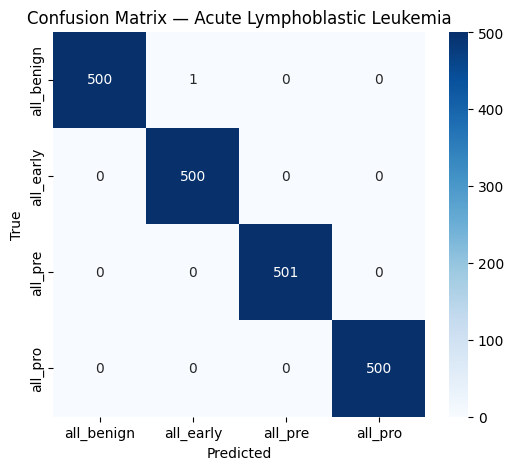


=== Alzheimers ===
                             precision    recall  f1-score   support

    Alzheimers_MildDemented       0.71      0.73      0.72       500
Alzheimers_ModerateDemented       1.00      1.00      1.00       500
     Alzheimers_NonDemented       0.80      0.58      0.67       500
Alzheimers_VeryMildDemented       0.51      0.63      0.56       500

                   accuracy                           0.73      2000
                  macro avg       0.75      0.73      0.74      2000
               weighted avg       0.75      0.73      0.74      2000



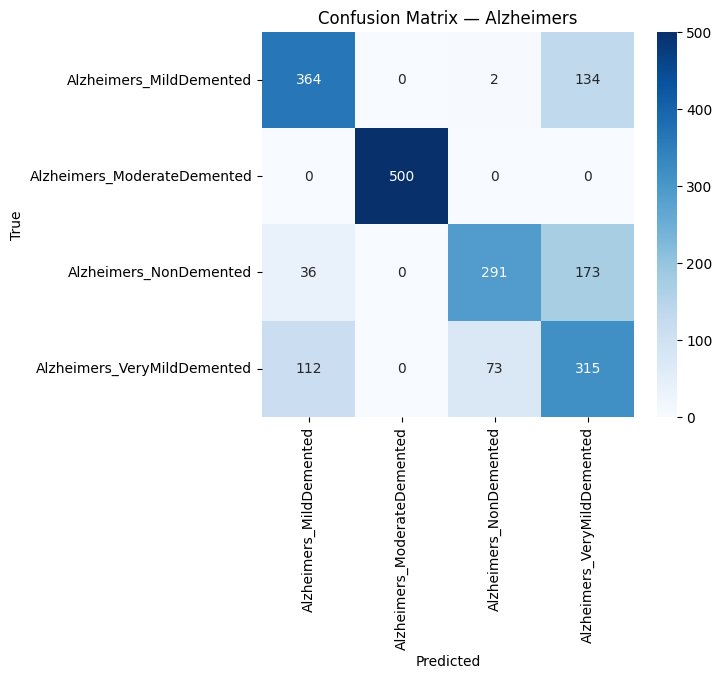


=== Neurological disease ===
              precision    recall  f1-score   support

brain_glioma       0.98      1.00      0.99       500
 brain_menin       0.99      0.94      0.96       500
 brain_tumor       0.96      0.99      0.98       500

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



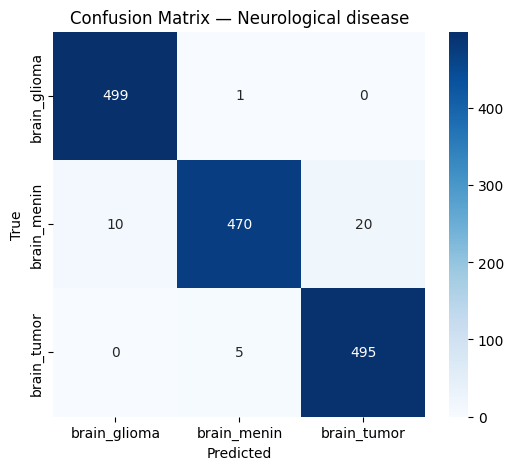


=== Breast Cancer ===
                  precision    recall  f1-score   support

   breast_benign       0.99      1.00      1.00       500
breast_malignant       1.00      0.99      1.00       497

        accuracy                           1.00       997
       macro avg       1.00      1.00      1.00       997
    weighted avg       1.00      1.00      1.00       997



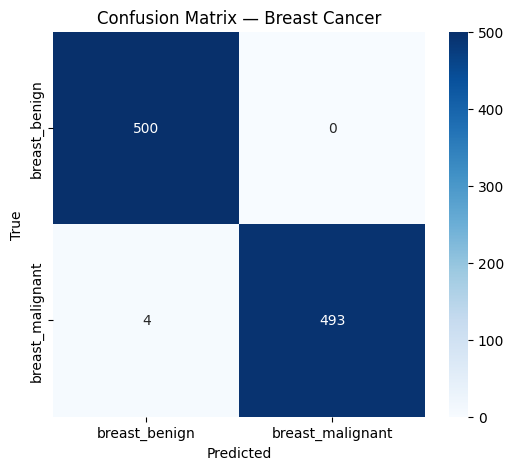


=== Kidney Cancer ===
               precision    recall  f1-score   support

kidney_normal       0.97      1.00      0.99       500
 kidney_tumor       1.00      0.97      0.99       500

     accuracy                           0.99      1000
    macro avg       0.99      0.99      0.99      1000
 weighted avg       0.99      0.99      0.99      1000



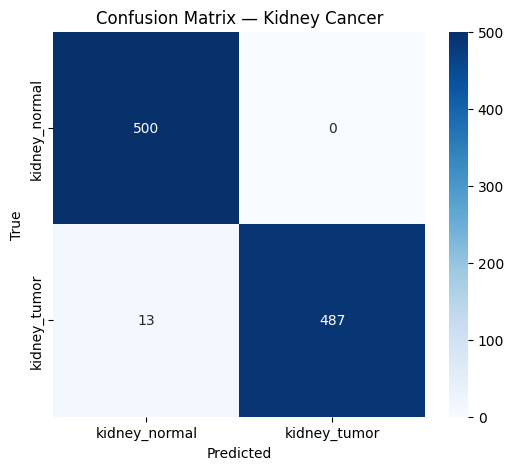


=== Lung & Colon Cancer ===
                              precision    recall  f1-score   support

        colon_adenocarcinoma       1.00      1.00      1.00       499
         colon_benign_tissue       1.00      1.00      1.00       500
         lung_adenocarcinoma       0.96      0.98      0.97       500
          lung_benign_tissue       1.00      1.00      1.00       500
lung_squamous_cell_carcinoma       0.98      0.96      0.97       501

                    accuracy                           0.99      2500
                   macro avg       0.99      0.99      0.99      2500
                weighted avg       0.99      0.99      0.99      2500



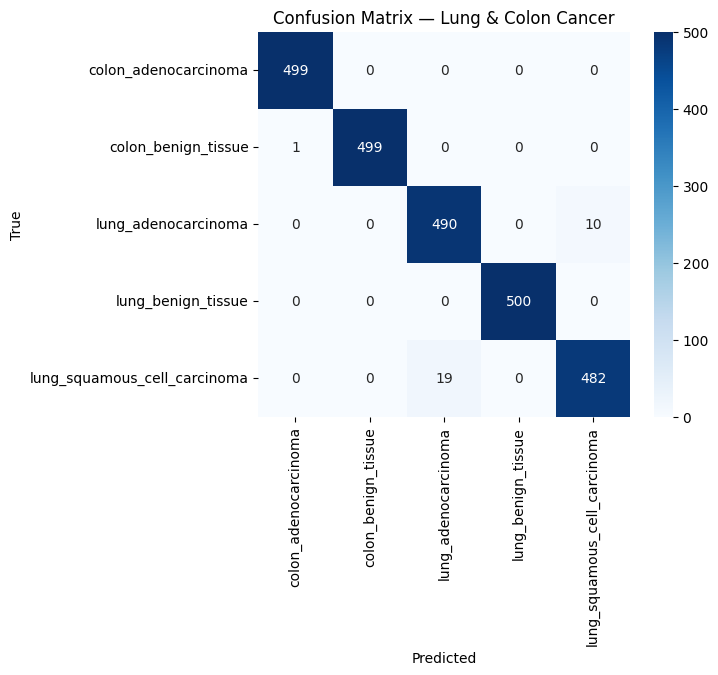


=== Lymphoma ===
                                    precision    recall  f1-score   support

lymph_chronic_lymphocytic_leukemia       0.89      1.00      0.94       500
         lymph_follicular_lymphoma       1.00      0.88      0.94       500
        lymph_mantle_cell_lymphoma       1.00      0.99      0.99       500

                          accuracy                           0.96      1500
                         macro avg       0.96      0.96      0.96      1500
                      weighted avg       0.96      0.96      0.96      1500



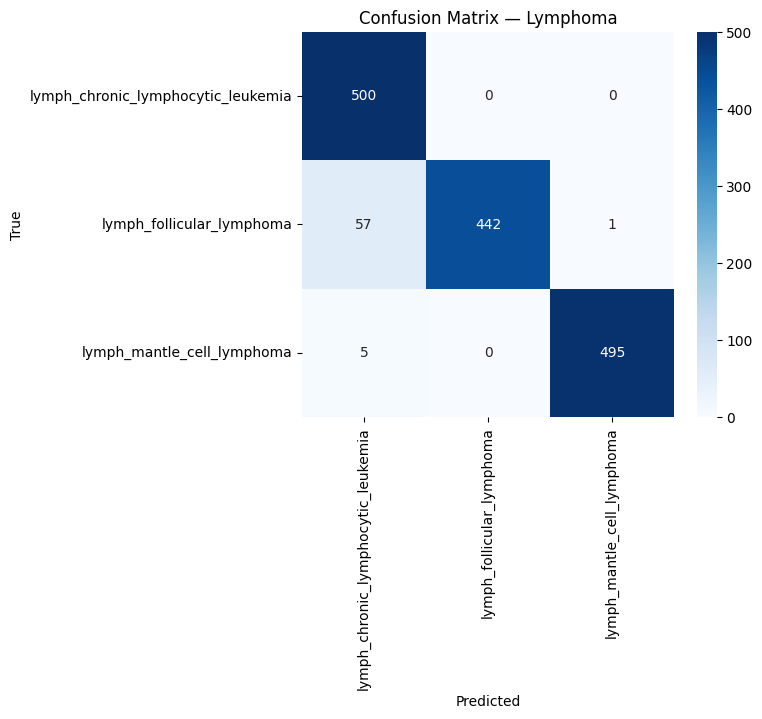


=== Oral Cancer ===
                              precision    recall  f1-score   support

                 oral_normal       0.93      0.87      0.90       500
oral_squamous_cell_carcinoma       0.88      0.93      0.90       500

                    accuracy                           0.90      1000
                   macro avg       0.90      0.90      0.90      1000
                weighted avg       0.90      0.90      0.90      1000



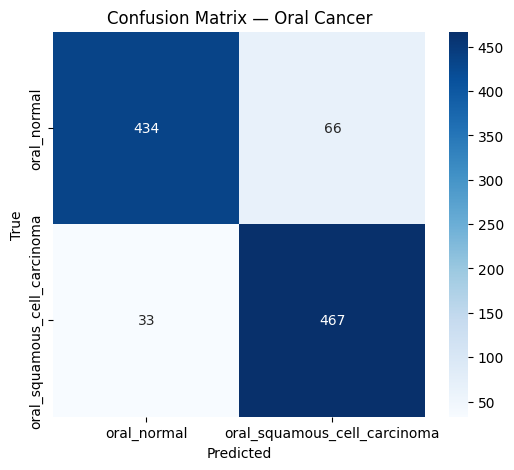


=== Cervical Cancer ===
                                 precision    recall  f1-score   support

            cervix_dyskeratotic       1.00      1.00      1.00       500
            cervix_koilocytotic       0.98      1.00      0.99       500
             cervix_metaplastic       1.00      1.00      1.00       500
               cervix_parabasal       1.00      1.00      1.00       500
cervix_superficial_intermediate       1.00      0.99      0.99       500

                       accuracy                           1.00      2500
                      macro avg       1.00      1.00      1.00      2500
                   weighted avg       1.00      1.00      1.00      2500



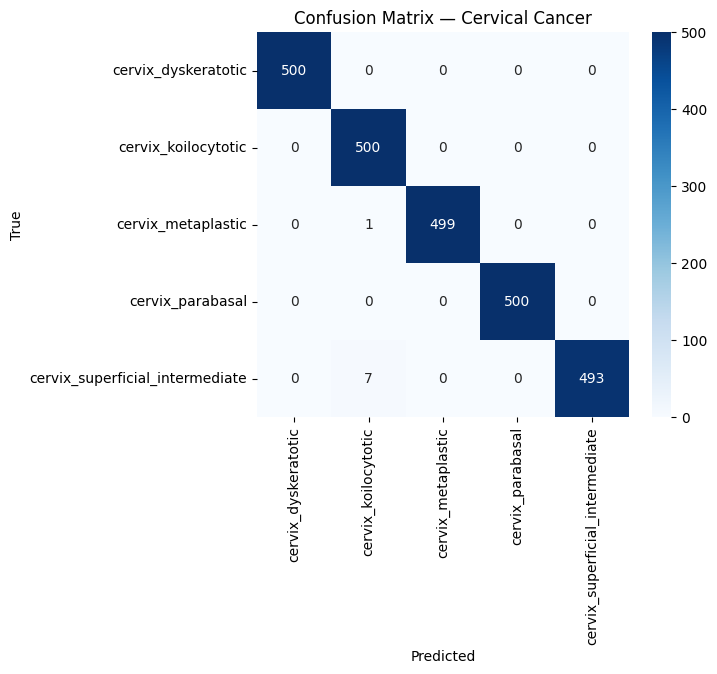

In [ ]:
# =======================================================
# CELL — Evaluation metrics per cancer type (safe version)
# =======================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1) Load best weights
model.load_weights(SAVE_DIR + "/best_model.weights.h5")
print("Loaded best model weights!")

# 2) Predict on the test set
y_true = []
y_pred = []

for batch_imgs, batch_labels in test_ds:
    probs = model.predict(batch_imgs, verbose=0)
    y_pred.extend(np.argmax(probs, axis=1))
    y_true.extend(np.argmax(batch_labels.numpy(), axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Map indices back to class names
class_names = [idx2label[i] for i in range(len(idx2label))]

# 3) Overall classification report
print("=== Overall Classification Report (all classes) ===")
print(classification_report(y_true, y_pred, target_names=class_names, digits=2))

# 4) Group classes by cancer type
cancer_groups = {
    "Acute Lymphoblastic Leukemia": [c for c in class_names if "all" in c.lower()],
    "Alzheimers": [c for c in class_names if c.startswith("Alzheimers_")],
    "Neurological disease": [c for c in class_names if "brain" in c.lower()],
    "Breast Cancer": [c for c in class_names if "breast" in c.lower()],
    "Kidney Cancer": [c for c in class_names if "kidney" in c.lower()],
    "Lung & Colon Cancer": [c for c in class_names if "lung" in c.lower() or "colon" in c.lower()],
    "Lymphoma": [c for c in class_names if "lymph" in c.lower()],
    "Oral Cancer": [c for c in class_names if "oral" in c.lower()],
    "Cervical Cancer": [c for c in class_names if "cervix" in c.lower()]
}

# 5) Safe per-group classification report + confusion matrix
for group_name, group_classes in cancer_groups.items():
    if not group_classes:
        continue

    print(f"\n=== {group_name} ===")
    group_idx = [class_names.index(c) for c in group_classes if c in class_names]

    # Filter samples where true label belongs to this group
    mask = np.isin(y_true, group_idx)
    if mask.sum() == 0:
        print("No samples in this group.")
        continue

    y_true_group = y_true[mask]
    y_pred_group = y_pred[mask]

    # Remap labels to local group indices
    idx_map = {old: new for new, old in enumerate(group_idx)}
    y_true_local = np.array([idx_map[i] for i in y_true_group])
    y_pred_local = np.array([idx_map.get(i, -1) for i in y_pred_group])  # -1 for predictions outside group

    # Filter out invalid predictions for classification report and confusion matrix
    valid_mask = y_pred_local != -1
    y_true_valid = y_true_local[valid_mask]
    y_pred_valid = y_pred_local[valid_mask]

    local_class_names = [class_names[i] for i in group_idx]

    # Classification report
    print(classification_report(y_true_valid, y_pred_valid, target_names=local_class_names, digits=2))

    # Confusion matrix
    cm = confusion_matrix(y_true_valid, y_pred_valid)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=local_class_names,
                yticklabels=local_class_names)
    plt.title(f"Confusion Matrix — {group_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
